Day 14 - We backtest with an easy strategy, take data from yfinance (py module), calculate returns and costs (we'll put some realistic costs), model the equity curves (cumulative returns), show basic metrics and plotting. After that we'll try to optimize the parameters to find better or worse results with different parameters on the strategy (with SMA's) and I might show some visualization (that is NOT matplotlib, but maybe a more advanced python module where we get better results) if I have time.

In [81]:
#IMPORTS + CHOICE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

ticker = 'SPY' #S&P 500 ETF
start_date = '2010-01-01'
end_date = '2025-04-10' #april 11th 2025


#DATA
#download data
print(f"Downloading {ticker} data...")
df = yf.download(ticker, start=start_date, end=end_date)
print("Data download complete.")

#keep only adjusted close for simplicity
df = df[['Close']].copy() 

print("\n\nInitial data :")
print(df.head(2)) #check data loaded (first lines)


#INDICATORS + SIGNALS
#indicator parameters, short windows = sma short value, 5 days, long = 20 days (so pretty long term)
short_window = 108
long_window = 119

#calculate SMAs
df['SMA'] = df['Close'].rolling(short_window).mean()
df['LMA'] = df['Close'].rolling(long_window).mean()

#generate signal (+1 for long, -1 for short)
df['Signal'] = np.where(df['SMA'] > df['LMA'], 1, -1)

#drop initial NaNs created by rolling windows
df.dropna(inplace=True)

print("\n\nIndicators and Signal calculated:")
print(df.head(2)) #check SMA, LMA, Signal columns


#POSITIONS
#positions are based on PREVIOUS day's signal
df['Position'] = df['Signal'].shift(1)

#fill the first NaN position with 0 (flat initially)
df['Position'].fillna(0, inplace=True)

print("\n\nPositions calculated:")
print(df[['Signal', 'Position']].head(2)) #check signal vs position shift

[*********************100%***********************]  1 of 1 completed

Data download complete.


Initial data :
Price           Close
Ticker            SPY
Date                 
2010-01-04  85.768425
2010-01-05  85.995506


Indicators and Signal calculated:
Price           Close        SMA        LMA Signal
Ticker            SPY                             
Date                                              
2010-06-23  83.400902  86.019765  86.056568     -1
2010-06-24  82.018906  85.981123  86.025060     -1


Positions calculated:
Price      Signal Position
Ticker                    
Date                      
2010-06-23     -1      NaN
2010-06-24     -1     -1.0




Returns and Costs calculated:
Price      AssetLogRet Signal Position StratLogRet Trade DailyCost  \
Ticker                                                               
Date                                                                 
2010-06-24   -0.016709     -1     -1.0    0.016709     0       0.0   
2010-06-25    0.004180     -1     -1.0   -0.004180     0       0.0   

Price      NetStratLogRet  
Ticker                     
Date                       
2010-06-24       0.016709  
2010-06-25      -0.004180  


Equity Curves calculated:
Price      NetStratEquity BuyHoldEquity
Ticker                                 
Date                                   
2025-04-08       3.471137      5.952933
2025-04-09       3.835673      6.578106

--- Performance Metrics ---
Net Strategy Total Return: 283.57%
Buy & Hold Total Return:   557.81%
Net Strategy Ann. Return:  9.53%
Buy & Hold Ann. Return:    13.60%
Net Strategy Ann. Vol:     17.31%
Buy & Hold Ann. Vol:       17.30%
Net Strategy Sh

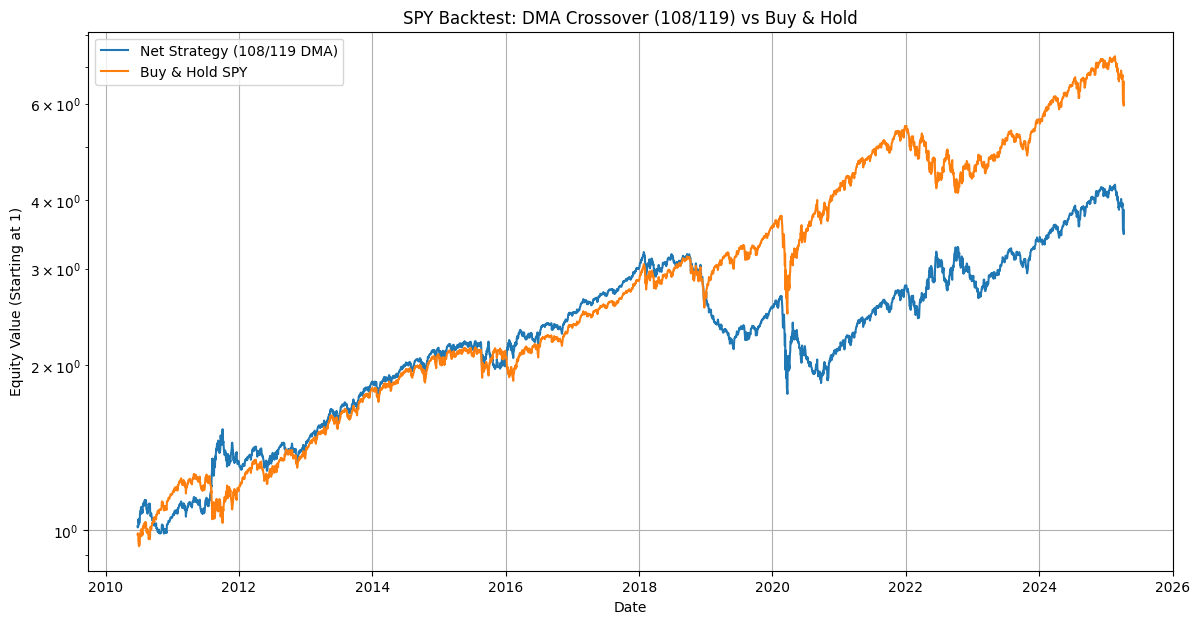

In [82]:
#RETURNS + COSTS + NET RETURNS
#calculate asset log returns
df['AssetLogRet'] = np.log(df['Close'] / df['Close'].shift(1))

#calculate theoretical strategy log returns
df['StratLogRet'] = df['Position'] * df['AssetLogRet']

#model costs
cost_pct = 0.0005 #5 basis points per trade turn (entry/exit) (0.05%)

#identify trades (when position changes from previous day)
#using diff().fillna(0) handles the first row after NaNs were dropped
df['PositionChange'] = df['Position'].diff().fillna(0)
df['Trade'] = np.where(df['PositionChange'] != 0, 1, 0)

#calculate daily cost (applied on trade days)
df['DailyCost'] = df['Trade'] * cost_pct

#calculate NET strategy log returns
df['NetStratLogRet'] = df['StratLogRet'] - df['DailyCost']

#drop any remaining NaNs (usually just the first row from return calc)
df.dropna(inplace=True)

print("\n\nReturns and Costs calculated:")
print(df[['AssetLogRet', 'Signal', 'Position', 'StratLogRet', 'Trade', 'DailyCost', 'NetStratLogRet']].head(2)) #check calculations

#EQUITY CURVES
#calculate cumulative returns
df['NetStratCumLogRet'] = df['NetStratLogRet'].cumsum() #cumulative sum
df['AssetCumLogRet'] = df['AssetLogRet'].cumsum()

#calculate equity curves (start at 1)
df['NetStratEquity'] = np.exp(df['NetStratCumLogRet']) 
df['BuyHoldEquity'] = np.exp(df['AssetCumLogRet']) 

print("\n\nEquity Curves calculated:")
print(df[['NetStratEquity', 'BuyHoldEquity']].tail(2)) #check final values


#METRICS CALCULATION
#metrics calculation (using Net Strategy Returns)
trading_days_per_year = 252 #standard assumption

#total return
net_strat_total_ret = df['NetStratEquity'].iloc[-1] - 1
bh_total_ret = df['BuyHoldEquity'].iloc[-1] - 1

#annualized return (geometric)
years = len(df) / trading_days_per_year
net_strat_ann_ret = (df['NetStratEquity'].iloc[-1])**(1/years) - 1
bh_ann_ret = (df['BuyHoldEquity'].iloc[-1])**(1/years) - 1

#annualized volatility (standard deviation of log returns)
net_strat_ann_vol = df['NetStratLogRet'].std() * np.sqrt(trading_days_per_year)
bh_ann_vol = df['AssetLogRet'].std() * np.sqrt(trading_days_per_year)

#sharpe ratio (assuming risk-free rate = 0)
net_strat_sharpe = net_strat_ann_ret / net_strat_ann_vol if net_strat_ann_vol != 0 else 0
bh_sharpe = bh_ann_ret / bh_ann_vol if bh_ann_vol != 0 else 0

#print metrics
print("\n--- Performance Metrics ---")
print(f"Net Strategy Total Return: {net_strat_total_ret:.2%}")
print(f"Buy & Hold Total Return:   {bh_total_ret:.2%}")
print(f"Net Strategy Ann. Return:  {net_strat_ann_ret:.2%}")
print(f"Buy & Hold Ann. Return:    {bh_ann_ret:.2%}")
print(f"Net Strategy Ann. Vol:     {net_strat_ann_vol:.2%}")
print(f"Buy & Hold Ann. Vol:       {bh_ann_vol:.2%}")
print(f"Net Strategy Sharpe Ratio: {net_strat_sharpe:.2f}")
print(f"Buy & Hold Sharpe Ratio:   {bh_sharpe:.2f}")
print(f"Number of Trades:          {df['Trade'].sum()}")


#PLOT
#plotting equity curves
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['NetStratEquity'], label=f'Net Strategy ({short_window}/{long_window} DMA)')
plt.plot(df.index, df['BuyHoldEquity'], label=f'Buy & Hold {ticker}')

plt.title(f'{ticker} Backtest: DMA Crossover ({short_window}/{long_window}) vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Equity Value (Starting at 1)')
plt.yscale('log') #log scale often better for long term equity curves
plt.legend()
plt.grid(True)
plt.show()

In [83]:
#function to run the backtest for given parameters
def run_dma_backtest(data_df, short_window, long_window, cost_pct=0.0005):
    #make a copy to avoid modifying original data outside function
    df = data_df[['Close']].copy() 
    
    #--- 1. Indicators & Signal ---
    df['SMA'] = df['Close'].rolling(short_window).mean()
    df['LMA'] = df['Close'].rolling(long_window).mean()
    df['Signal'] = np.where(df['SMA'] > df['LMA'], 1, -1)
    df.dropna(inplace=True) #important: drop NaNs AFTER signal calc based on MAs

    #--- 2. Positions ---
    df['Position'] = df['Signal'].shift(1)
    df['Position'].fillna(0, inplace=True)

    #--- 3. Returns, Costs, Net Returns ---
    df['AssetLogRet'] = np.log(df['Close'] / df['Close'].shift(1))
    df['StratLogRet'] = df['Position'] * df['AssetLogRet']
    df['PositionChange'] = df['Position'].diff().fillna(0)
    df['Trade'] = np.where(df['PositionChange'] != 0, 1, 0)
    df['DailyCost'] = df['Trade'] * cost_pct
    df['NetStratLogRet'] = df['StratLogRet'] - df['DailyCost']
    df.dropna(inplace=True) #drop first row NaN from return calc

    #--- 4. Metrics ---
    if df.empty: #handle cases where no data remains after drops
        return {'ShortW': short_window, 'LongW': long_window, 'Error': 'No data after initial calcs'}
        
    trading_days_per_year = 252
    
    #equity curve for total return calc
    net_strat_equity = np.exp(df['NetStratLogRet'].cumsum())
    net_strat_total_ret = net_strat_equity.iloc[-1] - 1
    
    #annualized return
    years = len(df) / trading_days_per_year
    net_strat_ann_ret = (net_strat_equity.iloc[-1])**(1/years) - 1 if years > 0 else 0

    #annualized volatility
    net_strat_ann_vol = df['NetStratLogRet'].std() * np.sqrt(trading_days_per_year)

    #sharpe ratio
    net_strat_sharpe = net_strat_ann_ret / net_strat_ann_vol if net_strat_ann_vol > 1e-6 else 0 #avoid division by zero

    #number of trades
    num_trades = df['Trade'].sum()

    #return results as a dictionary
    results = {
        'ShortW': short_window,
        'LongW': long_window,
        'TotalRet': net_strat_total_ret,
        'AnnRet': net_strat_ann_ret,
        'AnnVol': net_strat_ann_vol,
        'Sharpe': net_strat_sharpe,
        'Trades': num_trades
    }
    return results

In [84]:
#define parameter sets to test [(short_window, long_window)]
param_sets = [(10, 30), (20, 50), (50, 100), (50, 200)] 
#using the list we discussed earlier

#ensure original data df exists from Cell 2
#use the variable name used there, e.g., 'df_raw' if you saved the original
#or just re-download if easier
df_original = yf.download(ticker, start=start_date, end=end_date)[['Close']].copy()

#list to store results from each parameter set
all_results = []

print("\n--- Running Backtests for Different Parameters ---")
#loop through parameters
for short_w, long_w in param_sets:
    print(f"Testing: Short={short_w}, Long={long_w}")
    #ensure short window is less than long window
    if short_w >= long_w:
        print(" Skipping: short_window >= long_window")
        continue
    
    #run backtest using the function
    #pass the original downloaded data
    result_dict = run_dma_backtest(df_original, short_w, long_w, cost_pct=0.0005) 
    all_results.append(result_dict)

#convert results list to a pandas DataFrame
results_df = pd.DataFrame(all_results)

print("\n--- Parameter Test Results ---")
print(results_df)

[*********************100%***********************]  1 of 1 completed


--- Running Backtests for Different Parameters ---
Testing: Short=10, Long=30
Testing: Short=20, Long=50
Testing: Short=50, Long=100
Testing: Short=50, Long=200

--- Parameter Test Results ---
   ShortW  LongW  TotalRet    AnnRet    AnnVol    Sharpe  Trades
0      10     30  0.056887  0.003665  0.173978  0.021067     120
1      20     50 -0.072164 -0.004967  0.174349 -0.028486      77
2      50    100  0.516577  0.028450  0.173747  0.163745      27
3      50    200  1.211765  0.056477  0.172989  0.326477      12


In [85]:
#OPTIMIZATION 2 ??
import time

min_window = 5  #start from 5 maybe, very small windows noisy
max_window = 200 
gap = 5 #testing each 5
param_sets_full = []
for short_w in range(min_window, max_window, gap):
    for long_w in range(short_w, max_window + 1, gap): #ensure long > short
        param_sets_full.append((short_w, long_w))
        
print(f"Generated {len(param_sets_full)} parameter combinations to test.")

df_original = yf.download(ticker, start=start_date, end=end_date)[['Close']].copy()

all_results_full = []
start_loop_time = time.time() #time the loop

print("\n--- Running Backtests for Full Parameter Search ---")
#loop through parameters
for i, (short_w, long_w) in enumerate(param_sets_full):
    #print progress occasionally
    if (i + 1) % 100 == 0:
        print(f" Testing combination {i+1}/{len(param_sets_full)}...")
        
    #run backtest using the function
    result_dict = run_dma_backtest(df_original, short_w, long_w, cost_pct=0.0005) 
    all_results_full.append(result_dict)

end_loop_time = time.time()
print(f"\n--- Full Parameter Search Complete in {end_loop_time - start_loop_time:.2f}s ---")

#convert results list to a pandas DataFrame
results_full_df = pd.DataFrame(all_results_full)

#handle potential errors if function returned error strings
results_full_df_valid = results_full_df.dropna(subset=['Sharpe']) #drop rows with NaN Sharpe

print("\n--- Top 10 Parameter Sets by Sharpe Ratio (In-Sample) ---")
top_10_sharpe = results_full_df_valid.sort_values(by='Sharpe', ascending=False).head(10)
print(top_10_sharpe)

Generated 819 parameter combinations to test.


[*********************100%***********************]  1 of 1 completed


--- Running Backtests for Full Parameter Search ---


 Testing combination 100/819...
 Testing combination 200/819...
 Testing combination 300/819...
 Testing combination 400/819...
 Testing combination 500/819...
 Testing combination 600/819...
 Testing combination 700/819...
 Testing combination 800/819...

--- Full Parameter Search Complete in 20.59s ---

--- Top 10 Parameter Sets by Sharpe Ratio (In-Sample) ---
     ShortW  LongW  TotalRet    AnnRet    AnnVol    Sharpe  Trades
809     180    200  2.360558  0.087511  0.172959  0.505968      24
632     110    120  2.413004  0.086691  0.173015  0.501060      33
808     180    195  2.246924  0.084804  0.172876  0.490548      25
36        5    185  2.147802  0.082247  0.172720  0.476189      35
745     145    160  2.062106  0.079625  0.172743  0.460943      23
731     140    150  2.038912  0.078840  0.172763  0.456350      27
37        5    190  1.998331  0.078736  0.172841  0.455543      35
631     110    115  2.047411  0.078275  0.173066  0.452286      51
755     150    155  1.963463  0.

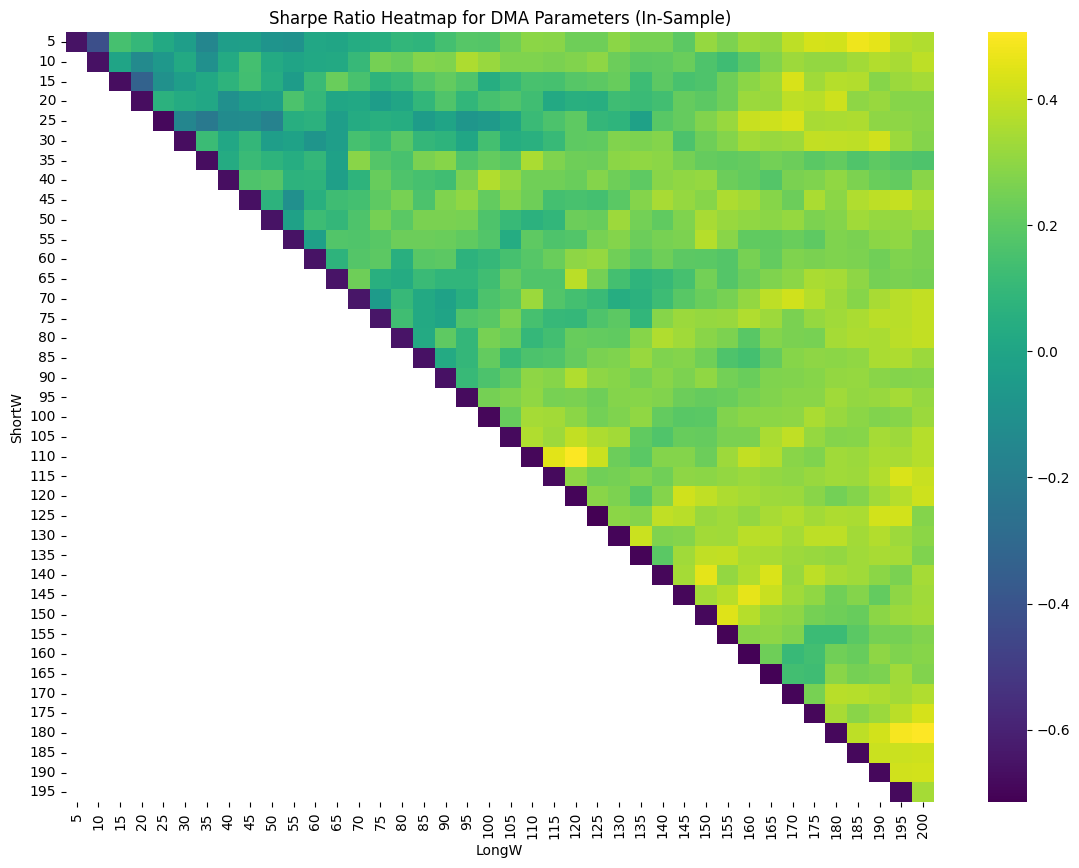

In [86]:
import seaborn as sns

results_pivot = results_full_df_valid.pivot(index='ShortW', columns='LongW', values='Sharpe')
plt.figure(figsize=(14, 10))
sns.heatmap(results_pivot, cmap='viridis', annot=False) #annot=True is too dense
plt.title('Sharpe Ratio Heatmap for DMA Parameters (In-Sample)')
plt.show()